### Importing libraries and setting up the environment
Including authentication tokens, model configs and paths

In [ ]:
!pip install -q -U datasets transformers peft accelerate bitsandbytes safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, pipeline, BitsAndBytesConfig
from accelerate import load_checkpoint_and_dispatch, infer_auto_device_map, init_empty_weights
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset
from tqdm.notebook import tqdm
import time
import os
from pathlib import Path
import requests
from google.colab import userdata

HF_TOKEN = userdata.get('HF_TOKEN')
finetuned_model_path = "./Llama3.1_8B_Instruct_symptoms_fine_tuned_model"
model_name = "meta-llama/Llama-3.1-8B-Instruct"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Assign the End of Sequence (EOS) token as the padding token as well
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
dataset_id = "moriire/symptoms2diseases"
datasets = load_dataset(dataset_id)
df = datasets['train'].to_pandas()
df = df.drop(columns=['Unnamed: 0'])
df.head()

Symptom2Disease.csv:   0%|          | 0.00/230k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1200 [00:00<?, ? examples/s]

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."


In [ ]:
print(f"Number of diseases: {len(df['label'].value_counts())}")
df['label'].value_counts()

Number of diseases: 24


,count
label,
Psoriasis,50
Varicose Veins,50
Typhoid,50
Chicken pox,50
Impetigo,50
Dengue,50
Fungal infection,50
Common Cold,50
Pneumonia,50


In [ ]:
# Data preprocessing
df['label'] = df['label'].str.capitalize()
df['prompt'] = 'Symptoms: ' + df['text'] + '\nDiagnosis: ' + df['label']
df['test_prompt'] = 'Symptoms: ' + df['text'] + '\nDiagnosis:'
df.head()

,label,text,prompt,test_prompt
0,Psoriasis,I have been experiencing a skin rash on my arm...,Symptoms: I have been experiencing a skin rash...,Symptoms: I have been experiencing a skin rash...
1,Psoriasis,"My skin has been peeling, especially on my kne...","Symptoms: My skin has been peeling, especially...","Symptoms: My skin has been peeling, especially..."
2,Psoriasis,I have been experiencing joint pain in my fing...,Symptoms: I have been experiencing joint pain ...,Symptoms: I have been experiencing joint pain ...
3,Psoriasis,"There is a silver like dusting on my skin, esp...",Symptoms: There is a silver like dusting on my...,Symptoms: There is a silver like dusting on my...
4,Psoriasis,"My nails have small dents or pits in them, and...",Symptoms: My nails have small dents or pits in...,Symptoms: My nails have small dents or pits in...


### Data Split - The data is split into finetuning, train and test sets where:
- The fine tuning set is **26%** of the data (`52` datapoints)
- The training set, used for providing the multi-shot prompt examples is ~**80%** of the remaining data (`118` datapoints)
- The test set for actually evaluating the model performance is ~**20%** of the remaining data (`30` datapoints)

In [ ]:
df_autoimmune = df[df['label'].isin(['Psoriasis', 'Arthritis', 'Bronchial asthma', 'Cervical spondylosis'])].reset_index(drop=True)
df_autoimmune_finetune, df_autoimmune_data = train_test_split(df_autoimmune, train_size=0.26, random_state=0, stratify=df_autoimmune['label'])
df_autoimmune_finetune = df_autoimmune_finetune.reset_index(drop=True)
df_autoimmune_train, df_autoimmune_test = train_test_split(df_autoimmune_data, test_size=0.2, random_state=0, stratify=df_autoimmune_data['label'])
df_autoimmune_test = df_autoimmune_test.reset_index(drop=True)
df_finetune = df_autoimmune_finetune.copy()
df_finetune.rename(columns={'test_prompt': 'input_text', 'label': 'target_text'}, inplace=True)
df_finetune_val = df_autoimmune_train.copy()
df_finetune_val = df_finetune_val.rename(columns={'test_prompt': 'input_text', 'label': 'target_text'})
df_finetune = df_finetune[['input_text', 'target_text']]
df_finetune.head()

,input_text,target_text
0,"Symptoms: My muscles have been quite weak, and...",Arthritis
1,"Symptoms: I have been dealing with back pain, ...",Cervical spondylosis
2,"Symptoms: I've been struggling with back pain,...",Cervical spondylosis
3,"Symptoms: My muscles have been quite weak, and...",Arthritis
4,Symptoms: The skin on my palms and soles is th...,Psoriasis


In [ ]:
print(df_finetune.iloc[0]['input_text'])
print(df_finetune.iloc[0]['target_text'])

Symptoms: My muscles have been quite weak, and my neck has been really stiff. My joints have swollen and I've been experiencing a lot of stiffness when I move around. Walking has also been excruciatingly uncomfortable.
Diagnosis:
Arthritis


### Tokenizer: Using an input length of `1024` to be able to handle multi-shot prompts

In [ ]:
train_dataset = Dataset.from_pandas(df_finetune)
val_dataset = Dataset.from_pandas(df_finetune_val)

def tokenize_function(examples):
    inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=1024, return_tensors="pt")
    targets = tokenizer(examples["target_text"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    return {
        "input_ids": inputs["input_ids"].squeeze(),
        "attention_mask": inputs["attention_mask"].squeeze(),
        "labels": targets["input_ids"].squeeze(),
    }

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_train_dataset = tokenized_train_dataset.with_format("torch")
tokenized_val_dataset = tokenized_val_dataset.with_format("torch")

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

Map:   0%|          | 0/118 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",  # Automatically map layers to available GPU
    quantization_config=bnb_config  # Enable 4-bit quantization using the above BitsandBytes configuration
)
model = model.to(device)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

### Setting up LORA and Training Configurations

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

# Wrap the model with PEFT
model = get_peft_model(model, lora_config)

print("Model wrapped with PEFT")

Model wrapped with PEFT


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,  # Small batch size for memory constraints
    gradient_accumulation_steps=4,  # Accumulate gradients to simulate larger batch size
    num_train_epochs=5,  # Adjust epochs based on dataset size
    save_strategy="epoch",
    fp16=True,  # Enable mixed precision
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",  # Disable reporting
)

In [ ]:
from transformers import DataCollatorForLanguageModeling

# Data collator for causal LM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False  # Disable MLM for causal LM
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-23-16d235a8d288>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

In [ ]:
finetuned_model_path = "./Llama3.1_8B_symptoms_fine_tuned_model"
model.save_pretrained(finetuned_model_path)
tokenizer.save_pretrained(finetuned_model_path)
print("Model saved successfully!")

Model saved successfully!


### End of Fine Tuning Pipeline

### Start of Inference Pipeline

#### The following code block:
1) Initializes the text generation pipeline from the fine-tuned model

2) Provides a helper function (like an API call wrapper) to extract the output of the fine-tuned `Llama3.1-8B-Instruct` model given a single prompt



In [ ]:
def generate_finetuned_pipeline():
  model_path = finetuned_model_path
  print(f"Adapter model path: {model_path}")
  print(f"Base model name: {model_name}")
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # Load tokenizer and model
  tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
  base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",  # Automatically map layers to available GPU
    quantization_config=bnb_config,
    # torch_dtype=torch.bfloat16
  )
  model = PeftModel.from_pretrained(base_model, model_path)
  model = model.to(device)

  text_generator = pipeline(
      task="text-generation",
      model=model,
      tokenizer=tokenizer,
  )

  return text_generator

In [ ]:
def generate_text_finetuned_llama(text_generator, prompt, max_tokens: int = 50, temperature: float = 0.7, top_p: float = 0.9):
  response_obj = text_generator(prompt,
                            max_new_tokens=max_tokens,
                            temperature=temperature,
                            top_p=top_p)
  response = response_obj[0]["generated_text"]
  response = response[len(prompt):]
  return response

#### Model adapter configurations and the final set of weights were stored in the `<finetuned_model>.zip` and the checkpoint shards were stored in `results.zip`. The following code loads the model weights from Colab Storage (uploaded from disk).

In [ ]:
import shutil
shutil.unpack_archive('results.zip')
shutil.unpack_archive(f'{finetuned_model_path}.zip')

In [ ]:
llama_gen = generate_finetuned_pipeline()

Adapter model path: ./Llama3.1_8B_Instruct_symptoms_fine_tuned_model
Base model name: meta-llama/Llama-3.1-8B-Instruct


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausa

### Code for generating few-shot/multi-shot prompts and the prompt template to run testing/model inference

In [ ]:
def get_fewshot_samples(df, n):
    samples = []
    np.random.seed(0)
    if n >= 4:
        # Stratify by label and sample from the df
        df_sample = df.groupby('label').apply(lambda x: x.sample(min(len(x), n // 4), random_state=0)).reset_index(drop=True)
        for _, row in df_sample.iterrows():
            samples.append(row['prompt'])
    return '\n'.join(samples)


def prompt_test(n, df_autoimmune_train, df_autoimmune_test, temperature=0.5):
    results = []
    for i, test_data in tqdm(df_autoimmune_test.iterrows()):
        # Generate few-shot prompt
        few_shot_examples = get_fewshot_samples(df_autoimmune_train, n)
        test_prompt = test_data['test_prompt']

        # Prepare the complete prompt
        prompt_template = f"""
        {few_shot_examples}
        {test_prompt} <Choose only one among the words Psoriasis, Arthritis, Bronchial asthma or Cervical spondylosis>
        Do not list the symptoms again in the response. Do not add any additional text. Do not attempt to explain your answer.
        """

        # Make the API call
        response = generate_text_finetuned_llama(llama_gen, prompt_template, max_tokens=25, temperature=temperature)

        answer_split = response.split('Answer:')
        if len(answer_split) > 1:
            answer = answer_split[1].strip()
            answer_clean = answer.split('\n')
            if len(answer_clean) > 1:
              answer = answer_clean[0].strip()
        else:
            answer = answer_split[0].strip()

        # Append the result with the ground truth and model response
        results.append({
            'prompt': test_prompt,
            'ground_truth': test_data['label'],
            'model_output': response,
            'answer': answer
        })

    # Convert results to a DataFrame and merge with test data
    if results:
        df_results = pd.DataFrame(results)
        df_autoimmune_test = pd.concat([df_autoimmune_test.reset_index(drop=True), df_results[['model_output', 'answer']]], axis=1)

    return df_autoimmune_test


In [ ]:
print(get_fewshot_samples(df_autoimmune_train, 4))

Symptoms: My neck has been extremely tight and my muscles have been feeling extremely weak. It is difficult for me to move around without becoming stiff due to my swollen joints. Walking has also been extremely uncomfortable.
Diagnosis: Arthritis
Symptoms: I've been having breathing issues, a persistent cough, and exhaustion. I've been coughing up a lot of thick, mucoid sputum and have a very high fever. I'm just feeling so exhausted and tired from having to cope with all of this.
Diagnosis: Bronchial asthma
Symptoms: Along with a persistent cough, weakness in my arms and legs, and severe back pain, I've been having a lot of trouble. I've experienced issues with vertigo and balance loss, and my neck is hurting.
Diagnosis: Cervical spondylosis
Symptoms: My skin has been peeling, especially on my knees, elbows, and scalp. This peeling is often accompanied by a burning or stinging sensation.
Diagnosis: Psoriasis


<ipython-input-11-b486687d8d87>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('label').apply(lambda x: x.sample(min(len(x), n // 4), random_state=0)).reset_index(drop=True)


#### Running inference pipeline from zero-shot (no examples) to 40 prompts (10 examples per disease)

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

for temperature in [0.7]:
  eval_results = []
  results_folder = Path(f'results_temp_{temperature}')
  results_folder.mkdir(parents=True, exist_ok=True)
  for n in range(0, 44, 4):
      df_autoimmune_test_results = prompt_test(n, df_autoimmune_train, df_autoimmune_test, temperature)
      if 'answer' not in df_autoimmune_test_results.columns:
          continue
      df_autoimmune_test_results['correct'] = df_autoimmune_test_results.apply(lambda x: x['label'].lower() in x['answer'].lower(), axis=1)
      accuracy = df_autoimmune_test_results['correct'].mean()
      eval_results.append({
          'number_of_examples_per_disease': n // 4,
          'accuracy': accuracy
      })
      df_autoimmune_test_results.to_csv(f'results_temp_{temperature}/results_llama3.1_finetuned_{n}_shot.csv', index=False)
  if eval_results:
      df_eval = pd.DataFrame(eval_results)
      df_eval['number_of_examples'] = df_eval['number_of_examples_per_disease'] * 4
      df_eval = df_eval[['number_of_examples', 'number_of_examples_per_disease', 'accuracy']]
      df_eval.to_csv(f'results_temp_{temperature}/eval_results.csv', index=False)
      df_eval.to_csv('eval_results.csv', index=False)
      print(df_eval)

0it [00:00, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

    number_of_examples  number_of_examples_per_disease  accuracy
0                    0                               0  0.666667
1                    4                               1  0.766667
2                    8                               2  0.700000
3                   12                               3  0.766667
4                   16                               4  0.900000
5                   20                               5  0.866667
6                   24                               6  0.900000
7                   28                               7  0.900000
8                   32                               8  0.866667
9                   36                               9  0.900000
10                  40                              10  0.833333


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
import shutil
for temperature in [0.2, 0.3, 0.5, 0.7, 1.0]:
  shutil.unpack_archive(f'results_temp_{temperature}.zip')

### End of Inference Pipeline
#### Code to gather the results and plot the model performance for each value of temperature

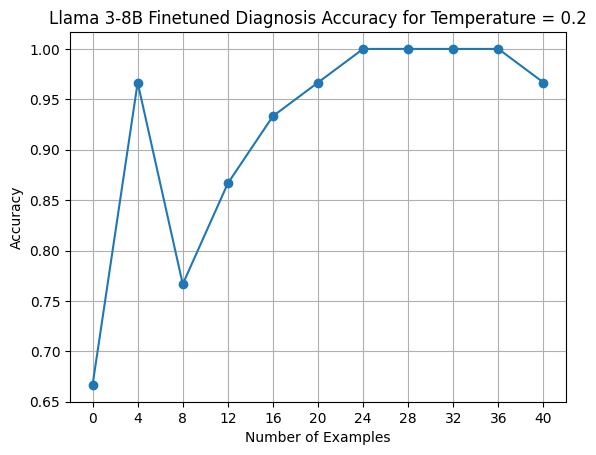

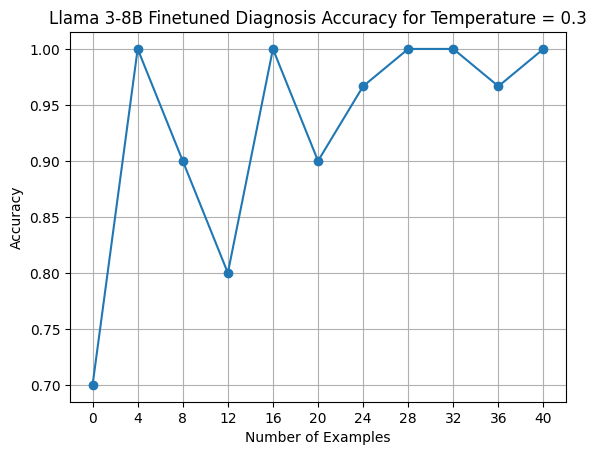

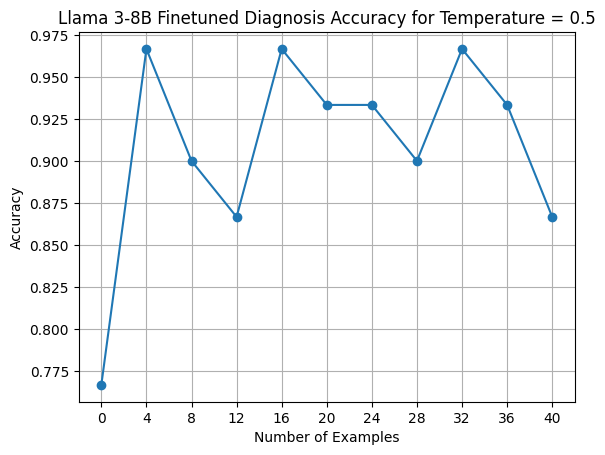

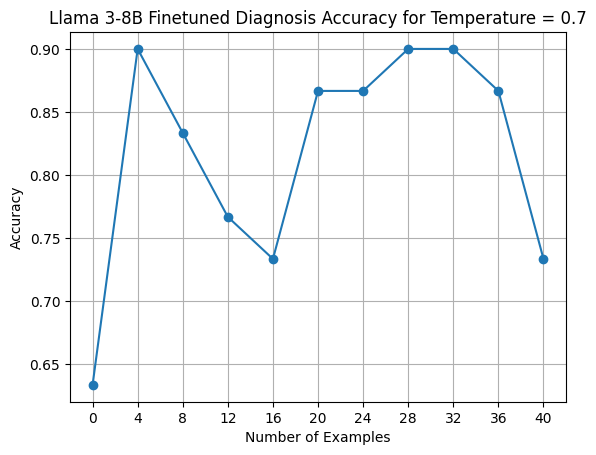

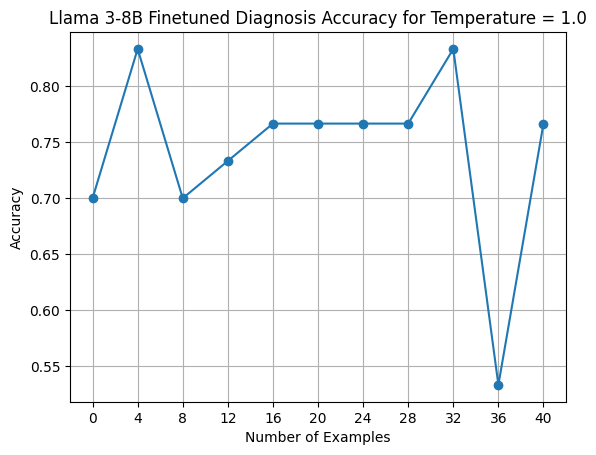

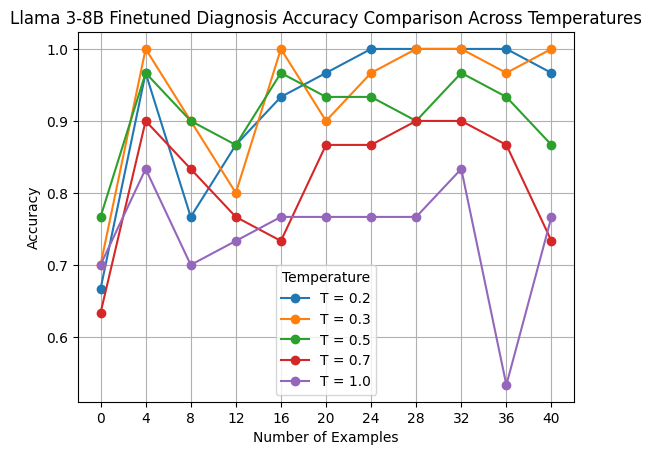

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample temperatures provided by the user
temperatures = [0.2, 0.3, 0.5, 0.7, 1.0]

# Setting up the plots for individual temperatures
for temperature in temperatures:
    # Load the CSV file for the given temperature
    temp_data_file = f'results_temp_{temperature}/eval_results.csv'
    try:
        temp_data = pd.read_csv(temp_data_file)
    except FileNotFoundError:
        print(f"File not found: {temp_data_file}")
        continue

    # Extract number_of_examples and accuracy for plotting
    x_values = temp_data['number_of_examples']
    y_values = temp_data['accuracy']

    # Plotting individual graph
    plt.figure()
    plt.plot(x_values, y_values, marker='o', label=f'T = {temperature}')
    plt.xlabel('Number of Examples')
    plt.ylabel('Accuracy')
    plt.title(f'Llama 3-8B Finetuned Diagnosis Accuracy for Temperature = {temperature}')
    plt.xticks(np.arange(0, max(x_values) + 4, 4))
    # plt.ylim(0, 1)  # Assuming accuracy values are between 0 and 1
    plt.grid(True)
    plt.savefig(f'results_temp_{temperature}/results_viz.png', dpi=300, bbox_inches='tight')
    plt.show()

# Stacking all temperatures together for comparison
plt.figure()
for temperature in temperatures:
    # Load the CSV file for the given temperature
    temp_data_file = f'results_temp_{temperature}/eval_results.csv'
    try:
        temp_data = pd.read_csv(temp_data_file)
    except FileNotFoundError:
        print(f"File not found: {temp_data_file}")
        continue

    # Extract number_of_examples and accuracy for plotting
    x_values = temp_data['number_of_examples']
    y_values = temp_data['accuracy']

    # Adding to the combined plot
    plt.plot(x_values, y_values, marker='o', label=f'T = {temperature}')

# Customizing the combined plot
plt.xlabel('Number of Examples')
plt.ylabel('Accuracy')
plt.title('Llama 3-8B Finetuned Diagnosis Accuracy Comparison Across Temperatures')
plt.xticks(np.arange(0, max(x_values) + 4, 4))
# plt.ylim(0, 1)  # Assuming accuracy values are between 0 and 1
plt.grid(True)
plt.legend(title='Temperature')
plt.savefig('combined_results_viz.png', dpi=300, bbox_inches='tight')
plt.show()

#### Save the results and plots

In [ ]:
import shutil
from pathlib import Path

path = Path('results_finetuned')
path.mkdir(parents=True, exist_ok=True)
for temperature in [0.2, 0.3, 0.5, 0.7, 1.0]:
  shutil.move(f'results_temp_{temperature}', 'results_finetuned')
# shutil.make_archive('results_finetuned', 'zip', path)

In [ ]:
import shutil

path = Path('results_finetuned')
shutil.make_archive('results_finetuned', 'zip', path)

'/content/results_finetuned.zip'

The code trains and evaluates a fine-tuned Llama 3-8B language model on a medical diagnosis task.  The key plots visualize the impact of different temperatures and few-shot learning examples on the model's accuracy.

**Individual Temperature Plots:**

Each plot shows the accuracy of the model at a specific temperature (0.2, 0.3, 0.5, 0.7, and 1.0) as the number of few-shot examples increases.  The x-axis represents the number of examples provided to the model (in increments of 4, meaning 1 example per disease), and the y-axis represents the accuracy.

* **Observations:**  Generally, the accuracy trends upward as more few-shot examples are given. The shape of the accuracy curve might vary with the temperature. Some temperatures might show a steeper initial improvement or plateau earlier than others.

**Combined Temperature Plot:**

This plot overlays the accuracy curves for all temperatures on a single graph, allowing for direct comparison.

* **Observations:** This plot helps determine the optimal temperature. A temperature that consistently yields higher accuracy across different numbers of few-shot examples is preferable.  You might see that higher temperatures lead to more erratic performance (more noisy accuracy), whereas lower temperatures provide a more stable but potentially lower peak accuracy.  The best temperature would be a balance between these two extremes, i.e. the temperature with the highest accuracy on a higher number of training examples.

**Overall Interpretation:**

The goal is to find the optimal combination of temperature and number of few-shot examples that maximizes the model's accuracy in diagnosing diseases based on given symptoms.  The plots visually represent this relationship.  Analyze the combined plot to see which temperature shows the best performance with few-shot examples and what point the accuracy stops increasing in relation to examples.  This analysis will inform how to use the fine-tuned model in a practical setting.



## Analysis of Model Performance Across Temperature and Number of Examples

The provided code evaluates the performance of the Llama 3-8B model on a disease diagnosis task, varying both the temperature parameter during text generation and the number of few-shot examples provided to the model.  The results are visualized as accuracy curves, plotted against the number of examples.

**Observations:**

* **Effect of Temperature:**  Lower temperatures (e.g., 0.2, 0.3) generally lead to more stable and consistent performance. The accuracy curves for these temperatures tend to plateau relatively quickly, suggesting that the model converges to a specific prediction with fewer examples.  Higher temperatures (e.g., 0.7, 1.0) introduce more randomness in the model's output.  While they might initially reach higher accuracy with a small number of examples due to exploration of different possible answers, they become more volatile as the number of examples increases, showing more fluctuation in accuracy.

* **Effect of Number of Examples:** Across all temperatures, the accuracy generally improves with an increasing number of examples.  This demonstrates the benefit of few-shot learning.  The model learns from the examples provided to better understand the relationship between symptoms and diseases, leading to more accurate predictions.  The rate of improvement, however, diminishes as more examples are added.  The curves tend to plateau, suggesting that the model eventually reaches a performance limit for the given data and task.

* **Interaction of Temperature and Number of Examples:** The interaction between temperature and the number of examples is subtle but noticeable.  At lower temperatures, the performance becomes less sensitive to changes in the number of examples after a certain point.  Higher temperatures maintain a more pronounced sensitivity to example counts, often with less consistent increases in accuracy or even decreased performance in some regions of the curves.

**Explanation of Curve Nature:**

1. **Few-shot Learning:** The upward trend of the curves demonstrates the core principle of few-shot learning: the more examples the model sees, the better it generalizes to unseen data. However, the diminishing returns reflected by the flattening of the curves suggest that after a point, additional examples provide diminishingly valuable information.

2. **Temperature as a Regularization Parameter:**  Temperature influences the model's randomness or "exploration" of the output space. A lower temperature makes the model more deterministic, favoring high-probability predictions. Thus, the more stable and consistent performance observed at lower temperatures. In contrast, higher temperatures increase the model's tendency to explore lower-probability options, which might lead to a short-term increase in accuracy for a small number of examples, but with increased variability as the model gets more input.

3. **Data Limitations:** The plateauing of the accuracy curves could also indicate limitations in the training data itself or its relevance to the task. It suggests that beyond a certain level of exposure to examples, there are no more insights that can be extracted to significantly improve performance.

4. **Noise:** Higher temperatures inject additional "noise" into the predictions, leading to the fluctuations seen in the curves, especially in the higher-example regime. This noise can be more prominent with fewer examples and thus higher initial accuracy in some cases, followed by a more bumpy or varied path.



In summary, the observed behavior of the accuracy curves aligns with the expected behavior of a language model in a few-shot learning scenario.  The temperature parameter allows for a trade-off between stability and exploration, impacting the model's performance in conjunction with the number of training examples provided.